## Tutorial Portfolio Allocation with BNP Paribas Asset Management

Notebook by Max Pommier, Hugo Yérémian, Simon Teherc, William Roche and Ethan Trentin. 

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.optimize import minimize

Exercice 1 : Efficient frontier 

We will first define the correlation matrix $\rho$ and the vector of volatility $\sigma$ for the stocks AAPL (Apple), GOOGL (Google), MSFT (Microsoft), AMZN (Amazon), META (Meta), TSLA (Tesla), GS (Goldman Sachs) & Cash. 

In [76]:
mu = np.array([0.072,0.032,0.067,0.039,0.063,0.052,0.05,0])
sigma = np.array([0.18,0.12,0.16,0.13,0.14,0.13,0.12,0.005])
rho = np.array([[1,   0.47, 0.38, 0.35, 0.40, 0.25, 0.80, 0], 
               [0.47,    1, 0.10, 0.15, 0.75,-0.20, 0.36, 0], 
               [0.38, 0.10,    1,-0.23, 0.05, 0.10, 0.25, 0], 
               [0.35, 0.15,-0.23,    1,-0.23, 0.11, 0.13, 0],
               [0.40, 0.75, 0.05,-0.23, 1,   -0.08, 0.31, 0],
               [0.25,-0.20, 0.10, 0.11,-0.08,    1, 0.64, 0],
               [0.80, 0.36, 0.25, 0.13, 0.31, 0.64,    1, 0],
               [0,       0,    0,    0,    0,    0,    0, 1]])
kappa = 0.2

In [77]:
## Just to check that rho was correctly defined
rho.T == rho

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [78]:
## We define the covariance matrix thanks to the correlation matrix
n = len(mu) # Number of stocks considered
Sigma = np.zeros((n,n))
for i in range(n):
  for j in range(n):
    Sigma[i,j] = rho[i,j]*sigma[i]*sigma[j]
Sigma

array([[ 3.2400e-02,  1.0152e-02,  1.0944e-02,  8.1900e-03,  1.0080e-02,
         5.8500e-03,  1.7280e-02,  0.0000e+00],
       [ 1.0152e-02,  1.4400e-02,  1.9200e-03,  2.3400e-03,  1.2600e-02,
        -3.1200e-03,  5.1840e-03,  0.0000e+00],
       [ 1.0944e-02,  1.9200e-03,  2.5600e-02, -4.7840e-03,  1.1200e-03,
         2.0800e-03,  4.8000e-03,  0.0000e+00],
       [ 8.1900e-03,  2.3400e-03, -4.7840e-03,  1.6900e-02, -4.1860e-03,
         1.8590e-03,  2.0280e-03,  0.0000e+00],
       [ 1.0080e-02,  1.2600e-02,  1.1200e-03, -4.1860e-03,  1.9600e-02,
        -1.4560e-03,  5.2080e-03,  0.0000e+00],
       [ 5.8500e-03, -3.1200e-03,  2.0800e-03,  1.8590e-03, -1.4560e-03,
         1.6900e-02,  9.9840e-03,  0.0000e+00],
       [ 1.7280e-02,  5.1840e-03,  4.8000e-03,  2.0280e-03,  5.2080e-03,
         9.9840e-03,  1.4400e-02,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  2.5000e-05]])

In [79]:
Omega = np.diag(np.diag(Sigma))
Omega

array([[3.24e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00],
       [0.00e+00, 1.44e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 2.56e-02, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 1.69e-02, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.96e-02, 0.00e+00,
        0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.69e-02,
        0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.44e-02, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 2.50e-05]])

a. Plot the efficient frontier based on Markowitz optimization with the following constraints : no investment in cash, short selling investment is allowed to one notional (-100%), leverage is allowed up to two notionals (200%) and we also have the constraint of full investment. Can you plot the
efficient frontier from a volatility of 12% until 18% ? 

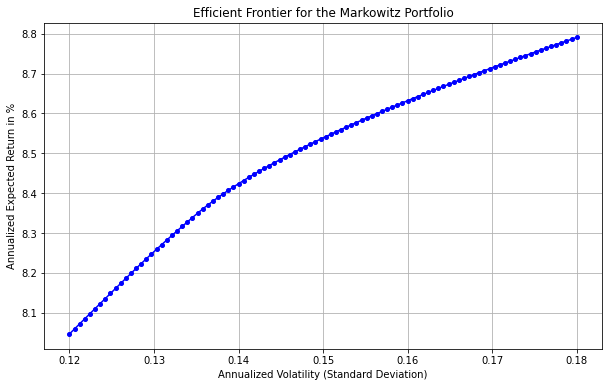

In [84]:
vector_risk = np.linspace(0.12, 0.18, 100)

expected_returns = []
markowitz_weights = []

for risk in vector_risk:
  w = cp.Variable(n)
  objective = cp.Maximize(mu.T @ w)
  constraints = [
    cp.sum(w) == 1,             # Full investment constraint
    w >= -1,                    # Short selling allowed up to -100% : it concerns each stock
    cp.norm1(w) <= 2,           # Leverage constraint (sum of absolute weights ≤ 200%) : the leverage is on the whole portfolio
    w[-1]==0,                   # No investment in cash
    w.T @ Sigma @ w <= risk**2, # Risk constraint
]

  prob = cp.Problem(objective, constraints)
  result = prob.solve()

  if prob.status == 'optimal':
    expected_returns.append(result*100)
    markowitz_weights.append(w.value)
  else:
    expected_returns.append(np.nan) # To handle cases where optimization fails

plt.figure(figsize=(10, 6))
plt.plot(vector_risk, expected_returns, marker='o', linestyle='-', color = "b", markersize=4)
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Expected Return in %')
plt.title('Efficient Frontier for the Markowitz Portfolio')
plt.grid(True)
plt.show()

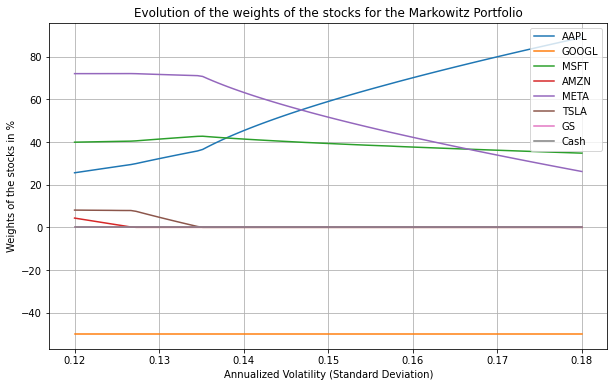

In [ ]:
weights = np.array(markowitz_weights).T*100
colors = plt.get_cmap("tab10").colors
stocks = ["AAPL","GOOGL","MSFT","AMZN","META","TSLA","GS","Cash"]

plt.figure(figsize=(10, 6))
for stock in range(len(stocks)):
    plt.plot(vector_risk, weights[stock], linestyle='-', color=colors[stock%len(colors)], label = f"{stocks[stock]}")
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Weights of the stocks in %')
plt.title('Evolution of the weights of the stocks for the Markowitz Portfolio')
plt.grid(True)
plt.legend()
plt.show()

b. On the same chart, can you add the efficient frontier based on Robust Optimization with the same constraints ? 

Let's consider the following optimization problem :  
$$w_{rob} = argmax(\overline{\mu}^Tw-\kappa\sqrt{w^T \Omega w})$$

where $w_{rob}$ is the vector of the assets weights, $\overline{\mu}$ the vector of returns, $\kappa$ the return error aversion parameter and $\Omega$ the error variance-covariance matrix.

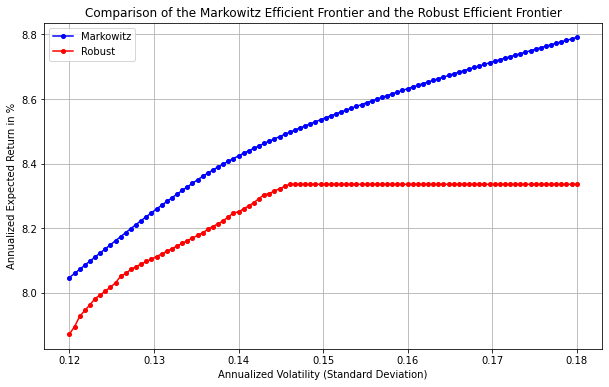

In [95]:
def objective_function(w):
    return - (mu.T @ w - kappa * np.sqrt(w.T @ Omega @ w))

def constraint_sum_to_one(w):
    return np.sum(w) - 1

def constraint_short_selling(w):
    return w+1

def constraint_leverage(w):
    return 2 - np.sum(np.abs(w))

## Bounds for weights
bounds = [(0, 0) if i == n-1 else (-1, 2) for i in range(n)]
## So we have w[-1]=0 meaning no investment on cash.

robust_returns = []
robust_weights = []

for risk in vector_risk:
    # Initial guess for weights (e.g., equally weighted)
    w0 = np.ones(n) / n

    def constraint_risk(w):
        return risk**2-w.T @ Sigma @ w  
    # Constraints definition for scipy.optimize.minimize
    constraints = ({'type': 'eq', 'fun': constraint_sum_to_one},
                {'type': 'ineq', 'fun': constraint_short_selling},
                {'type': 'ineq', 'fun': constraint_risk},
                {'type': 'ineq', 'fun': constraint_leverage})
    # Optimization
    result = minimize(objective_function, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    # Print results
    if result.success:
        w_rob = (result.x)
        robust_returns.append((mu.T @ w_rob) * 100)
        robust_weights.append(w_rob)


plt.figure(figsize=(10, 6))
plt.plot(vector_risk, expected_returns, marker='o', linestyle='-', color = "b", markersize=4, label = "Markowitz")
plt.plot(vector_risk, robust_returns, marker='o', linestyle='-', color = "r", markersize=4, label = "Robust")
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Expected Return in %')
plt.title('Comparison of the Markowitz Efficient Frontier and the Robust Efficient Frontier')
plt.grid(True)
plt.legend()
plt.show()

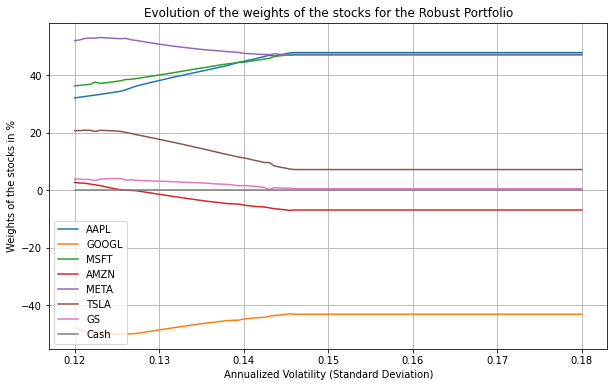

In [97]:
weights = np.array(robust_weights).T*100
colors = plt.get_cmap("tab10").colors
stocks = ["AAPL","GOOGL","MSFT","AMZN","META","TSLA","GS","Cash"]

plt.figure(figsize=(10, 6))
for stock in range(len(stocks)):
    plt.plot(vector_risk, weights[stock], linestyle='-', color=colors[stock%len(colors)], label = f"{stocks[stock]}")
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Weights of the stocks in %')
plt.title('Evolution of the weights of the stocks for the Robust Portfolio')
plt.grid(True)
plt.legend()
plt.show()

c. Explain these results ! 

- The Markowitz frontier is build using the historical inputs for expected returns and covariances without accounting for uncertainties or estimation errors. Therefore, when incorporating and penalizing the estimation errors through the use of the $\kappa$ parameter, we end up with a more conservative portfolio : as we can see on the weights, the allocations are less on the risky assets that are penalized due to their higher volatility. The curve of the Robust optimization frontier is lower because the portfolio is more conservative and is more diverse. 

- Also, the slope of the Robust frontier is flatter for higher risk levels : it tends to a plateau as the model becomes more cautious with extreme allocations when risk increases. This reflects a trade-off between risk and return, where the optimization prioritizes less sensitivity to uncertainty over maximizing the returns.

- We can see that the short-selling constraint limits the extreme risk-taking and creates smoother frontiers.

- The leverage constraint limits the weight allocation and forbids excessive exposure. It flattens the frontiers when the risk increases as it becomes impossible to exploit risky assets with high-return opportunities. 

- The no cash investment constraint makes the slopes steeper as it would be with cash, as cash has a zero-return and a small-volatility. 

d. Based on the same inputs and using Markowitz, can you plot the efficient frontier with the following constraints : no cash, short sell not allowed, no leverage and full investment. Can you plot the efficient frontier for volatility from 12% until 18% ?

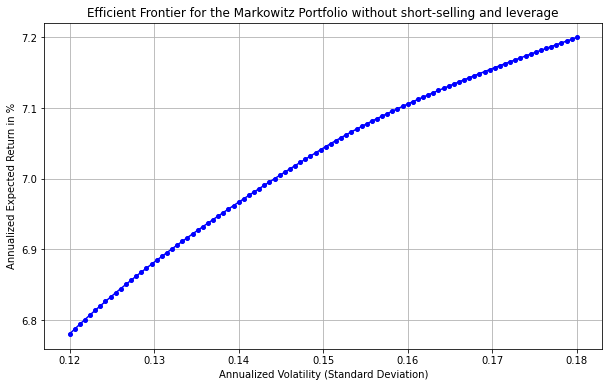

In [99]:
vector_risk = np.linspace(0.12, 0.18, 100)

expected_returns_no_leverage = []
markowitz_weights_no_leverage = []

for risk in vector_risk:
  w = cp.Variable(n)
  objective = cp.Maximize(mu.T @ w)
  constraints = [
    cp.sum(w) == 1,             # Full investment constraint
    w >= 0,                     # Short selling not allowed : positive constraint on the weights
    w[-1]==0,                   # No investment in cash
    w.T @ Sigma @ w <= risk**2, # Risk constraint
]

  prob = cp.Problem(objective, constraints)
  result = prob.solve()

  if prob.status == 'optimal':
    expected_returns_no_leverage.append(result*100)
    markowitz_weights_no_leverage.append(w.value)
  else:
    expected_returns_no_leverage.append(np.nan) # To handle cases where optimization fails

plt.figure(figsize=(10, 6))
plt.plot(vector_risk, expected_returns_no_leverage, marker='o', linestyle='-', color = "b", markersize=4)
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Expected Return in %')
plt.title('Efficient Frontier for the Markowitz Portfolio without short-selling and leverage')
plt.grid(True)
plt.show()

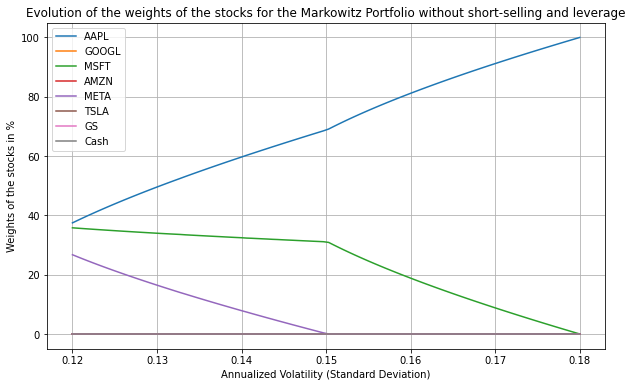

In [100]:
weights_no_leverage = np.array(markowitz_weights_no_leverage).T*100
colors = plt.get_cmap("tab10").colors
stocks = ["AAPL","GOOGL","MSFT","AMZN","META","TSLA","GS","Cash"]

plt.figure(figsize=(10, 6))
for stock in range(len(stocks)):
    plt.plot(vector_risk, weights_no_leverage[stock], linestyle='-', color=colors[stock%len(colors)], label = f"{stocks[stock]}")
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Weights of the stocks in %')
plt.title('Evolution of the weights of the stocks for the Markowitz Portfolio without short-selling and leverage')
plt.grid(True)
plt.legend()
plt.show()

 e. On the same chart, can you add the efficient frontier including cash with volatility starting from 1% to 20% ?

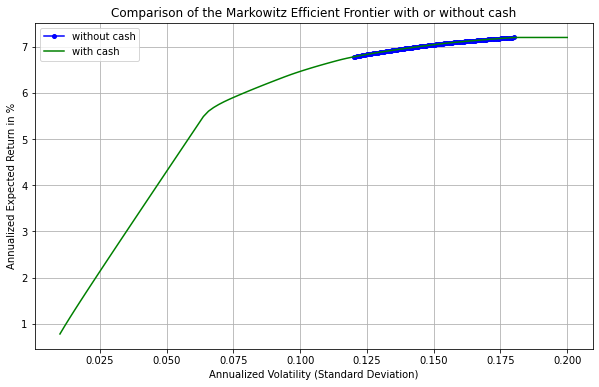

In [102]:
vector_risk_cash = np.linspace(0.01, 0.20, 100)

expected_returns_cash = []
markowitz_weights_cash = []

for risk in vector_risk_cash:
  w = cp.Variable(n)
  objective = cp.Maximize(mu.T @ w)
  constraints = [
    cp.sum(w) == 1,             # Full investment constraint
    w >= 0,                     # Short selling not allowed : positive constraint on the weights
    w.T @ Sigma @ w <= risk**2, # Risk constraint
]

  prob = cp.Problem(objective, constraints)
  result = prob.solve()

  if prob.status == 'optimal':
    expected_returns_cash.append(result*100)
    markowitz_weights_cash.append(w.value)
  else:
    expected_returns_cash.append(np.nan) # To handle cases where optimization fails

plt.figure(figsize=(10, 6))
plt.plot(vector_risk, expected_returns_no_leverage, marker='o', linestyle='-', color = "b", markersize=4, label = "without cash")
plt.plot(vector_risk_cash, expected_returns_cash, linestyle='-', color = "g", markersize=4, label = "with cash")
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Expected Return in %')
plt.title('Comparison of the Markowitz Efficient Frontier with or without cash')
plt.grid(True)
plt.legend()
plt.show()

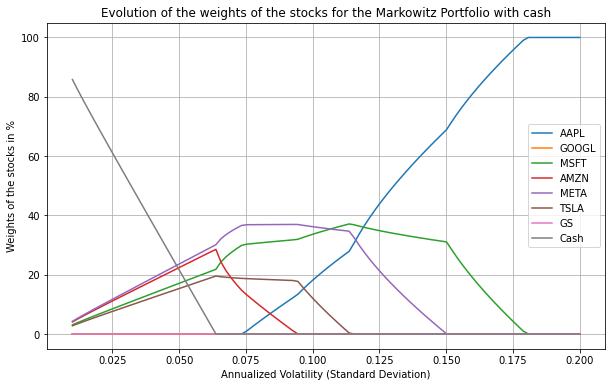

In [104]:
weights_cash = np.array(markowitz_weights_cash).T*100
colors = plt.get_cmap("tab10").colors
stocks = ["AAPL","GOOGL","MSFT","AMZN","META","TSLA","GS","Cash"]

plt.figure(figsize=(10, 6))
for stock in range(len(stocks)):
    plt.plot(vector_risk_cash, weights_cash[stock], linestyle='-', color=colors[stock%len(colors)], label = f"{stocks[stock]}")
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Weights of the stocks in %')
plt.title('Evolution of the weights of the stocks for the Markowitz Portfolio with cash')
plt.grid(True)
plt.legend()
plt.show()

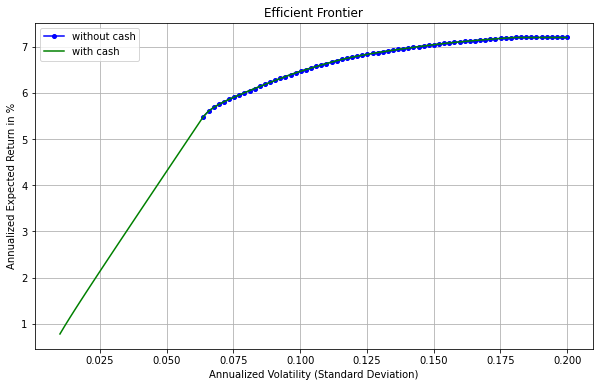

In [ ]:
vector_risk = np.linspace(0.01, 0.20, 100)

expected_returns_ = []

for risk in vector_risk:
  w = cp.Variable(n)
  objective = cp.Maximize(mu.T @ w)
  constraints = [
    cp.sum(w) == 1,             # Full investment constraint
    w >= 0,                     # Short selling not allowed : positive constraint on the weights
    w[-1]==0,                   # No investment in cash
    w.T @ Sigma @ w <= risk**2, # Risk constraint
]

  prob = cp.Problem(objective, constraints)
  result = prob.solve()

  if prob.status == 'optimal':
    expected_returns.append(result*100)
  else:
    expected_returns.append(np.nan) # To handle cases where optimization fails

plt.figure(figsize=(10, 6))
plt.plot(vector_risk, expected_returns, marker='o', linestyle='-', color = "b", markersize=4, label = "without cash")
plt.plot(vector_risk_cash, expected_returns_cash, linestyle='-', color = "g", markersize=4, label = "with cash")
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Expected Return in %')
plt.title('Efficient Frontier')
plt.grid(True)
plt.legend()
plt.show()

f. Explain these results ! 

- We can see that the portfolio with cash allows to start at a much lower risk than the portfolio without cash. Indeed, it offers a nearly risk-free option as the volatility of cash is equal to $0.5%$. 
The portfolio without cash can only allocate weights to risky assets and allocates fully the portfolio to the most risky asset when the volatility is maximal. 

- In the beginning i.e the low-risk region, the slope is steeper for the portfolio with cash because it allows to create a portfolio mainly composed of cash as we can see on the weights graph and mixing risky assets with a near-zero-risk component. So, a small increase in risk is rewarded with relatively higher returns. In the maximum volatility ($> 18%$), it puts all the weight on the riskiest asset.

- So, adding cash improves the flexibility of portfolio optmization, as a broader range of volatility is covered. 

Exercice 2 : Risk based

Minimum variance, equally weighted, ...

Exercice 3 : Tactical portfolio

$$w_{rob} = argmax(\overline{\mu}^Tw- \kappa \sqrt{w^T \Omega w}-\frac{\lambda}{2}w^T \Sigma w)$$
with $w_{rob}$ the weights of actif portfolio, $\overline{\mu}$ the expected returns, $\kappa$ the uncertainty on return, $\lambda$ the risk aversion, $\Sigma$ variance-covariance matrix and $\Omega$ the uncertainty matrix. We base ourself on the same data as exercise one.  

In [108]:
W_eq = np.array([0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.30])
kappa = 0.2 
Lambda = 13.3
risk_budget = 0.05

a. You anticipate a slowdown of APPL with a score of $-30 \%$, a recovery of MSFT with a score of $40 \%$ and a fall for GS with a score of $-40 \%$. Your fund has a risk budget of tracking error $= 5 \%$. What is the unconstrained portfolio integrated in risk budget from this strategy (tactical portfolio)?

In [107]:
score_views = np.array([-0.30, 0, 0.40, 0, 0, 0, -0.40, 0])
## Indeed, there is a slowdown of APPL with a score of -30%, a recovery of MSFT with a score of 40%
## and a fall for GS with a score of -40%. 
mu = score_views * sigma

In [109]:
def objective(w):
    return -(mu.T @ (w-W_eq) - kappa * np.sqrt((w-W_eq).T @ Omega @ (w-W_eq)) - Lambda/2 * (w-W_eq).T @ Sigma @ (w-W_eq))

def tracking_error_constraint(w):
    return risk_budget - np.sqrt((w-W_eq).T @ Sigma @ (w-W_eq))

constraints = [{'type':'ineq', 'fun': tracking_error_constraint}]

result = minimize(objective, W_eq, constraints=constraints, method = "SLSQP")
w_unconstrained = result.x
print("Unconstrained Tactical Portfolio Weights: ", w_unconstrained)
print("Tracking Error: ", np.sqrt((w_unconstrained-W_eq).T @ Sigma @ (w_unconstrained-W_eq)))

Unconstrained Tactical Portfolio Weights:  [-0.04554507  0.17179245  0.35521439  0.24686913  0.21335645  0.26558173
 -0.19872838  0.29759637]
Tracking Error:  0.04314881573077604


In [124]:
print("Proportion of GOOGL stock :", w_unconstrained[1]/sum(w_unconstrained)*100, "%")
print("Proportion of MSFT stock :", w_unconstrained[2]/sum(w_unconstrained)*100, "%")
print("Proportion of AMZN stock :", w_unconstrained[3]/sum(w_unconstrained)*100, "%")
print("Proportion of META stock :", w_unconstrained[4]/sum(w_unconstrained)*100, "%")
print("Proportion of TSLA stock :", w_unconstrained[5]/sum(w_unconstrained)*100, "%")

Proportion of GOOGL stock : 13.152712045741191 %
Proportion of MSFT stock : 27.195797381035476 %
Proportion of AMZN stock : 18.90070613803936 %
Proportion of META stock : 16.334920376438745 %
Proportion of TSLA stock : 20.33337361914024 %


As we anticipate a slowdown of APPL and of GS, the weights associated are negative : we will short sell those stocks. A third of the portfolio is allocated to MSFT that will experience a recovery, and almost one fifth for each of the following stock, that doesn't slowdown or recover : GOOGL, AMZN, META, TSLA. 

b. What is the value of vector $\overline{\mu}$ obtained from your tactical portfolio ? 

In [114]:
expected_return = (kappa* Omega @ w_unconstrained)/(np.sqrt(w_unconstrained.T@Omega@w_unconstrained))+Lambda*Sigma@w_unconstrained
print("Vector of expected returns from tactical views:", np.round(expected_return,3))

Vector of expected returns from tactical views: [0.082 0.06  0.122 0.032 0.061 0.045 0.036 0.   ]


The biggest return is made on the stock MSFT as it has the most important weight associated in the portfolio and a great recovery. The short-selling of the APPL stock enables to have the second most important return. The other stocks have pretty much similar returns going from 0.06 to 0.036, except for cash whose return is really close to 0 which makes sense as cash return is set to 0 (but it has a small volatility). 

c.  What is the final portfolio, i.e. your benchmark integrating your management views, with the maximum tracking error constraint of $5 \%$, the weight positivity constraint and the weight sum constraint $= 1$ ?

In [117]:
def constraint_sum_to_one(w):
    return np.sum(w) - 1

def constraint_non_negative(w):
    return w

## Constraints definition for scipy.optimize.minimize
constraints = ({'type':'ineq', 'fun': tracking_error_constraint},
               {'type': 'eq', 'fun': constraint_sum_to_one},
                {'type': 'ineq', 'fun': constraint_non_negative})

result_final = minimize(objective, W_eq, constraints=constraints, method = "SLSQP")
w_rob_final = result_final.x
print("Unconstrained Tactical Portfolio Weights: ", np.round(w_rob_final,3))

Unconstrained Tactical Portfolio Weights:  [-0.     0.12   0.286  0.186  0.156  0.15  -0.     0.103]


Therefore, with the constraint of positivity, it becomes impossible to short-sell the APPL and the GS stock. We can see their weights are set to 0. The biggest stock in terms of weights is the best performing one, MSFT. The other ones account for between $10 \%$ and $20 \%$ of the portfolio. 
The constraint of full investment makes the sum of the weights equal to 1. 

d. What is the tracking error of this portfolio compared to the Benchmark?

The tracking error is by definition the standard deviation of the difference between the returns of a portfolio and its benchmark. Therefore, for the benchmark, the difference in the weights is equal to 0. So, the tracking error of the benchmark is equal to 0.

In [118]:
print("Tracking Error compared to the benchmark (equal to 0 by definition): ", np.sqrt((w_rob_final-W_eq).T @ Sigma @ (w_rob_final-W_eq)))

Tracking Error compared to the benchmark (equal to 0 by definition):  0.026539633748370657


So, the tracking error of the constrained portfolio is less than the tracking error of the unconstrained one (around $0.043$). Indeed, the adding of constraints and especially the positivity constraint that forbids short-selling, creates a less risky and more conservative portfolio. 

The tracking error will therefore be less significant and closer to the benchmark one. 